<center>
<br>
<font size="36pt">Prime Spectroscopy</font><br><br>
<span style="font-size:1.5em;">
Florian Breuer<br>
University of Newcastle, Australia<br>
florian.breuer@newcastle.edu.au<br><br>   
    Number Theory Down Under 9</span>

<table>
    <tr><td><img src="https://www.newcastle.edu.au/__data/assets/file/0011/661727/uon-logo-square.svg" width="50px"></td>
        <td><img src="https://carma.newcastle.edu.au/images/carma_logo.png" width="150px"></td>
        <td><img src="https://amsi.org.au/wp-content/uploads/2015/11/amsi-main-logo-mobile.png" width="150px"></td>
    </tr>
<table>


<br><br>

<span style="font-size:1.5em;">
<b>Acknowledgement:</b> This grew out of a 2020-2021 AMSI Vacation Research Scholarship project by Cameron Shaw-Carmody.
Many thanks to Cameron, who contributed early code to this project and without whom this would never have happened.

https://github.com/florianbreuer/PrimeSpectroscopy   
</span>
 </center> 


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

This is my talk at <a href="https://www.maths.usyd.edu.au/NTDU9/" target="_blank">Number Theory Down Under 9</a>,
<h1>Prime Spectroscopy</h1>
    
To see my talk, convert this notebook to a slideshow (press Alt-R if you have RISE installed) or scroll down a few cells. If you want to play with the code, execute the next few cells first. The first cell
will precompile some code using cython, which takes a little time. Be patient, these routines will run much faster later.

Florian Breuer, University of Newcastle, Australia
florian.breuer@newcastle.edu.au

In [160]:
%%cython

from sage.arith.misc import is_prime_power
from sage.misc.functional import numerical_approx
from sage.functions.log import log
from sage.functions.trig import sin, cos

def vM_Lambda(x):
    '''Von Mangoldt Lambda function, for Chebychev psi function'''
    (p,k) = is_prime_power(x, get_data=True)
    if k>0:
        return numerical_approx(log(p))
    else:
        return 0
    
def Lambda_simple(x):
    '''Simpler Lambda function, for Chebychev theta function'''
    (p,k) = is_prime_power(x, get_data=True)
    if k==1:
        return numerical_approx(log(p))
    else:
        return 0
    
def Lambda_4(x):
    '''Von Mangoldt function for the \chi_4 Dirichlet character'''
    (p,k) = is_prime_power(x, get_data=True)
    if k>0:
        if p == 2:
            chi = 0
        elif p%4 == 1:
            chi = 1
        else:
            chi = -1
        return (chi**k)*numerical_approx(log(p))
    else:
        return 0
    
def Lambda_4_half(x):
    '''Simpler Lambda fucntion, counting only powers of primes 1 mod 4'''
    (p,k) = is_prime_power(x, get_data=True)
    if k>0:
        if p == 2:
            chi = 0
        elif p%4 == 1:
            chi = 1
        else:
            chi = 0
        return (chi**k)*numerical_approx(log(p))
    else:
        return 0

# The following two functions compute the Fourier transforms of a function given by a list M
# of (x,y) values.
    
def Fhat_sin(t, M, dx):
    return sum(y*sin(t*x) for (x,y) in M)*dx

def Fhat_cos(t, M, dx):
    return sum(y*cos(t*x) for (x,y) in M)*dx

In [2]:
# Here we collect a bunch of utilities for searching the LMFDB, downloading L-function data and 
# creating and searching a local database of L-functions.

import requests
import json

# The following function returns a dict continaing info about one L-function in the form we will use. 
# It's input is a dict obtained from https://www.lmfdb.org/api/lfunc_lfunctions/

def simple_data(entry):
    '''Extract only some of the Lfunction fields from data'''
    wanted_keys = ['label','rational', 'root_number', 'algebraic', 'order_of_vanishing', 'degree',
                  'conductor', 'primitive', 'origin', 'self_dual', 'motivic_weight', 'coefficient_field', 
                  'root_angle', 'conjugate']
    output = dict([])
    for k in wanted_keys:
        if k in entry:
            output[k] = entry[k]
        else:
            output[k] = ''
    output['positive_zeros'] = [float(z) for z in entry['positive_zeros']]
    output['link'] = "https://www.lmfdb.org/L/"+entry['label']
    return output


# The following downloads 100 entries from LMFDB to be inserted into the local database

def download_L_data(offset=0, motivic_weight=0):
    '''Downloads a page of L-function data from LMFDB. Returns a dict of entries with which to update 
    the local database.'''
    query_params = {"_format" : "json", 
                    "_motivic_weight" : motivic_weight,
                    "_offset" : offset     # this will be incremented
                   }
    try:
        response = requests.get("https://www.lmfdb.org/api/lfunc_lfunctions/", params=query_params)
    except:
        print('Unknown page load error.')
        return None
    if response.status_code != 200:
        print('Page load error: ', response.status_code, ' : ', response.reason)
        return None
    data = json.loads(response.text)
    return {entry['label'] : simple_data(entry) for entry in data['data']}


# This function will download a single L-function from LMFDB given its label:
def LMFDB_load(label='1-1-1.1-r0-0-0', verbose=True):
    '''Returns L_function_data for the L function identified by label in the LMFDB.'''                                                                            
    label = label.strip()
    query_params = {"_format" : "json", 
                    "label" : label
                   }
    try:
        response = requests.get("https://www.lmfdb.org/api/lfunc_lfunctions/", params=query_params)
    except:
        print('Unknown page load error.')
        return None
    if response.status_code != 200:
        print('Page load error: ', response.status_code, ' : ', response.reason)
        return None
    data = json.loads(response.text)
    return simple_data(data['data'][0])

In [3]:
import pickle

# # The following code, if you uncomment it, will download the first 10,000 entries from LMFDB 
# # (all of them Dirichlet L-functions), use them to populate the local database, and save to disk.

# pages = 100

# Local_database = {}

# for offset in range(pages):
#     print(f'Downloading page {offset+1}')
#     Local_database.update(download_L_data(offset*100))

# with open('LocalDatabase.pickle', 'wb') as f:
#     pickle.dump(Local_database, f)

# # Instead, we will load the local database from a pickle file:

with open('LocalDatabase.pickle', 'rb') as f:
    Local_database = pickle.load(f)
    
print(f'Local database contains {len(Local_database)} entries.')

RZ = Local_database['1-1-1.1-r0-0-0']  # this is the Riemann zeta function
print(RZ)

Local database contains 10000 entries.
{'label': '1-1-1.1-r0-0-0', 'rational': True, 'root_number': '1', 'algebraic': True, 'order_of_vanishing': 0, 'degree': 1, 'conductor': 1, 'primitive': True, 'origin': 'Character/Dirichlet/1/1', 'self_dual': True, 'motivic_weight': 0, 'coefficient_field': '1.1.1.1', 'root_angle': 0.0, 'conjugate': '', 'positive_zeros': [14.134725141734695, 21.022039638771556, 25.01085758014569, 30.424876125859512, 32.93506158773919, 37.586178158825675, 40.9187190121475, 43.327073280915, 48.00515088116716, 49.7738324776723, 52.970321477714464, 56.44624769706339, 59.34704400260235, 60.83177852460981, 65.1125440480816, 67.07981052949417, 69.54640171117398, 72.0671576744819, 75.70469069908393, 77.1448400688748, 79.33737502024937, 82.91038085408603, 84.73549298051705, 87.42527461312523, 88.80911120763446, 92.49189927055849, 94.65134404051989, 95.87063422824531, 98.83119421819369, 101.31785100573138], 'link': 'https://www.lmfdb.org/L/1-1-1.1-r0-0-0'}


In [154]:
# Now let's make a new "L-function", whose zeros are actually the 1/2-harmonics of those of the Riemann zeta function:

def L_harmonic(Lf,n):
    '''Returns a dict representing the L-function Lf, but with the positive zeros divided by n. 
    Change label to f"  {label} : {n}" and add key "harmonic"=n.'''
    output = {k : Lf[k] for k in Lf.keys()}
    output['label'] = f"h {Lf['label']} : 1/{n}"
    output['harmonic'] = n
    output['positive_zeros'] = [z/n for z in Lf['positive_zeros']]
    return output

RZ2 = {k : RZ[k] for k in RZ.keys()}
RZ2['label'] = '1/2 harmonics'
RZ2['positive_zeros'] = [z/2 for z in RZ['positive_zeros']]

RZ3 = {k : RZ[k] for k in RZ.keys()}
RZ3['label'] = '1/3 harmonics'
RZ3['positive_zeros'] = [z/3 for z in RZ['positive_zeros']]

L_harmonic(RZ, 4)

{'label': 'h 1-1-1.1-r0-0-0 : 1/4',
 'rational': True,
 'root_number': '1',
 'algebraic': True,
 'order_of_vanishing': 0,
 'degree': 1,
 'conductor': 1,
 'primitive': True,
 'origin': 'Character/Dirichlet/1/1',
 'self_dual': True,
 'motivic_weight': 0,
 'coefficient_field': '1.1.1.1',
 'root_angle': 0.0,
 'conjugate': '',
 'positive_zeros': [3.5336812854336737,
  5.255509909692889,
  6.252714395036422,
  7.606219031464878,
  8.233765396934798,
  9.396544539706419,
  10.229679753036875,
  10.83176832022875,
  12.00128772029179,
  12.443458119418075,
  13.242580369428616,
  14.111561924265848,
  14.836761000650588,
  15.207944631152452,
  16.2781360120204,
  16.769952632373542,
  17.386600427793496,
  18.016789418620476,
  18.92617267477098,
  19.2862100172187,
  19.834343755062342,
  20.727595213521507,
  21.183873245129263,
  21.856318653281306,
  22.202277801908615,
  23.122974817639623,
  23.662836010129972,
  23.967658557061327,
  24.707798554548422,
  25.329462751432846],
 'link': 

In [173]:
# Here is the main code for prime spectroscopy
# We define the class psi_function, which contains various methods for computing and displaying a psi function
# for a given Lambda-function, extracting the oscillating term, computing and analysing its Fourier transform, 
# searching the LMFDB for L-functions with zero corresponding to peaks in the Fourier transform, and more.

from numpy import arange
import ipywidgets as widgets
from bs4 import BeautifulSoup
from IPython.core.display import HTML
from sage.plot.colors import rgbcolor, mod_one

# first a little function for plotting bar codes corresponding to zeros of a given list of L-functions
def bar_codes(Lf_list, h_start=0.1, h_step=0.618, s=0.6, v=0.8, x_scale=1, y_scale=1, t_min=0, t_max=100):
    '''Return bar codes for the L-functions in Lf_list, coloured in hues from h_start in steps of h_step, module one.'''
    if len(Lf_list) == 0:
        return Graphics()
    cols = [rgbcolor([mod_one(h_start + k*h_step),s,v], space='hsv') for k in range(len(Lf_list)) ]
    p = sum(
    text(Lf['label'], (0,-0.1*y_scale*(i+1)), color=cols[i], 
         horizontal_alignment='left', vertical_alignment='top')+\
        sum(line([(x,-0.1*y_scale*(i+0.95)),(x,-0.1*y_scale*(i+0.2))], color=cols[i])+\
            line([(x,0),(x,y_scale)], color=cols[i])
            for x in Lf['positive_zeros'] if x<=t_max and x >=t_min)
        for i,Lf in enumerate(Lf_list)
    )
    return p

# Here is a simple binary search, used for searching the local database
def search_zeros_binary(zeros, z, epsilon):
    '''Search through zeros for matches in zList to a precision of epsilon.
    Return True if found'''
    if len(zeros) == 0:
        return False
    middle = len(zeros)//2
    if zeros[middle] > z+epsilon:
        return search_zeros_binary(zeros[:middle], z, epsilon)
    if zeros[middle] < z-epsilon:
        return search_zeros_binary(zeros[middle+1:], z, epsilon)
    else:
        return true
    
# And the following function searches the actual database for L-functions with zeros matching those in the given zList
def search_database(zList, epsilon=0.1, min_matches=2):
    '''Search the database for L-functions with positive zeros matching at least min_matches of the peaks listed 
    in zList, to a precision of epsilon.
    
    Returns a dict of the form {label : [sublistlist of matches in zList]}
    
    To do: 
      implement **kwargs for setting more conditions on other fields
      implement require matches to be consecutive zeros'''
    hits = {}
    for label in Local_database:
        Lf = Local_database[label]
        m = [z for z in zList if search_zeros_binary(Lf['positive_zeros'], z, epsilon)]
        if len(m) >= min_matches:
            hits.update({Lf['label'] : m})
    return hits

class psi_function(object):
    r'''Defines a psi-function of the form $\sum_{p^n\leq x}\Lambda(x)$, where \Lambda is the function typically
    given as the first parameter in __init__.
    
    The values of psi on the interval [0, X_data] are stored in a list self.data of (x,y)-values, where the sampled
    x-values are of the form x_n = x_1^n for suitable base value x_1 so that x_{N_points} = X_data.
    
    Usage: psi = psi_function(p, **kwargs), where
    
        l : either a function defining $\Lambda$, or a string.
            If l is a string, then it should be a label for an OEIS sequence, and the Lambda-function
            is defined by self.Lambda_oeis below, basically a Lambda-function for primes in the first few entries 
            of that OEIS sequence. If init_data=True (the default), then the sequence is retrieved from OEIS. 
            If the sequences is invalid, we use the default l="A000040" (all prime numbers). 
            Either way, if l is type string, then the OEIS widget is launched with psi_function.Spectroscope().
            
        Keyword arguments:
            
        load_from_file : (Default : None). If load_from_file='filename.txt', then the values of the psi function are 
                loaded from 'filename.txt' instead of computed. X_data and N_points are extracted from the file, too.
                
        X_data : (Default : 10^6). The values of psi are computed for the interval [0,X_data].
        
        X_pretty_plot : (Default: 1000). The values of psi are computed completely on the interval [0,X_pretty_plot] 
                as a list of values that can be plotted as a nice staircase graph using list_plot.
        
        N_points : (Default : 500). The number of datapoints in the list self.data.
        
        init_data : (Default: True). Computes the values in self.data upon initialisation.
        
        init_pretty_plot : (Default True). Computes the values in self.pretty_plot_data upon initialisation.
        
        init_linear_term : (Default: True). Computes the best-fit linear approximation to the psi-function.
        
        init_oscillating_term : (Default : True). Computes the oscillating error term, stores it in self.M
        
        extra_term : (Default : 0*x). This is a function of x that is subtracted off the oscillating term. 
                It must be formatted in a way can be fed to sage_eval() and produce a valid function of x, hence
                the strange way of representing the default value of 0.
                
        name : (Default : "Unspecified psi function"). The name of this psi-function, is displayed in 
                the self.Spectroscope() widget.
                
    Notable attributes:
    
        self.X : The endpoint of the interval on which the psi-function has been computed, initialised as X_data.
        self.N_points : the number of data points computed
        self.data : The data itself, as a list of (x,y) values, with x_0=1, x_n=x_1^n, and x_{N_points} = X.
        self.pretty_plot_data : a list of (x,y) points for list_plot-ing a pretty version over a shorter interval.
        self.M : The oscillating term, as a list of (x,y) values.
        self.FT : The Fourier transform of self.M, as a list of (t,y) values.
         
    Notable methods:
    
        Lambda_oeis : The Lambda function based on the OEIS sequence selected when a string is passed to the parameter l.
        oeis_init   : Retrieves the OEIS sequence specified
        save_data
        load_data
        compute_data
        compute_plottable
        linear_part
        log_rescale
        oscillating_part
        fourier_transform
        best_t
        find_peaks
        plot_peaks
        pretty_plot
        plot
        plot_oscillating_term
        plot_FT
        Spectroscope
        
    To Do:
    
        Improve the docstring.
        Show and search for harmonics of zeros.
        Find bug in find_peaks.
        Add extra search terms to online and local searches.
        Move various search methods from self.Spectroscope to self, so they can be used without the interface.
        Allow switching between two types of oeis Lambda function: with or without higher powers of primes.
        Page through all hits in local database search, or change page limit=20.
        Update Nyquist limits whenever self.X or self.N_points change.
            '''
    def __init__(self, 
                 l, 
                 load_from_file=None, 
                 X_data=10^6, 
                 X_pretty_plot=1000, 
                 N_points=500, 
                 init_data=True, 
                 init_pretty_plot=True, 
                 init_linear_term=True, 
                 init_oscillating_term=True, 
                 extra_term=0*x,
                 name = r'Unspecified $\psi$-function'):
    
        self.X = X_data              
        if type(l) == str:  # then we must use the oeis widget!
            self.oeis_label = l
            self.oeis_use = True
            self.l = self.Lambda_oeis
            self.oeis_set = {}
            self.oeis_list = []
            if init_data:
                self.oeis_init(l)  # fetches the oeis sequence with label l
#                 self.X = self.oeis_list[-1]+1
                if name == r'Unspecified $\psi$-function':
                    name= r'$\psi$-function for OEIS sequence'
        else:
            self.l = l                    # the Lambda-function used to define psi(x)
            self.oeis_use = False
            self.oeis_label = 'Not OEIS'
            
            
        self.data = []                # list of (x_i, psi(x_i)) points
        self.N_points = N_points      # number of sample points in self.data
        self.pretty_plot_data = []    # similar to self.data, but with vertical steps
        self.X_pretty_plot = X_pretty_plot # maximum X value of self.pretty_plot_data
        self.M = []                   # list of points of the oscillating term
        self.FT = []                  # list of points of the Fourier Transform
        self.FT_type = "pow"          # which Fourier transform was applied?
#         self.peaks = [((0,0),(0,0))]               # List of peaks in the Fourier transform
        self.peaks = []
        self.selected_peaks = []
#         self.fitted_peaks = []
        self.peaks_computed = False
        self.rf_min = 0.01
        self.m = 0                    # gradient of linear term
        self.c = 0                    # constant term
#         self.extra_term = lambda x : 0           # arbitrary addtional term to be subtracted from psi(x)
        self.post_scale_extra_term =  0   # arbitrary additional term to be subtracted from psi(log(x))
        self.comparison_L_functions = [RZ]  # list of known L-functions to compare to
        self.hits = []  # list of L-function found in local database
        self.data_filename = 'psi-data.txt'
        self.ft_filename = 'psi-ft.txt'
        self.name = name
        
        self.Compute_data_progress = widgets.IntProgress(min=0, max=self.X, value=0)
        self.Compute_FT_progress = widgets.FloatProgress(min=5, max=50, value=5)
        self.extra_term = extra_term
        
        if load_from_file != None:
            init_data = False
            self.load_data(load_from_file)
            self.data_filename=load_from_file
        
        if init_data:
            self.compute_data()
            if init_pretty_plot:
                self.compute_plottable(X_pretty_plot=X_pretty_plot)
            if init_linear_term:
                self.linear_part()
            if init_oscillating_term:
                self.oscillating_part()
            
    def __str__(self):
        return self.name
    
    def Lambda_oeis(self, x):
        (p,k) = is_prime_power(x, get_data=True)
        if p in self.oeis_set:    # should we allow all k or just k==1???
            return numerical_approx(log(p))
        else:
            return 0
        
    def oeis_init(self, label='A000040'):
        self.oeis = oeis(label)
        if not type(self.oeis) == sage.databases.oeis.OEISSequence:
            print(f'{label} does not return a unique sequence, loading A000040 prime numbers instead.')
            self.oeis = oeis('A000040')
            self.oeis_label = 'A000040'
        self.oeis_list = self.oeis.first_terms()
        self.oeis_set = set(self.oeis_list)
        self.X = self.oeis_list[-1]+1  # max X for psi function is one more than the largest prime in the list

    def save_data(self, filename=None, include_header=True):
        if filename == None:
            filename = self.data_filename
        with open(filename,'w') as f:
            if include_header:
                f.write('Lambda-function used: '+repr(self.l)+'\n')
                f.write('N_points: '+str(self.N_points)+'\n')
                f.write('X up to: '+str(self.X)+'\n')
            f.write('Data:\n')
            for a in self.data:
                f.write(str(a)+'\n')
                
    def load_data(self, filename=None):
        if filename == None:
            filename = self.data_filename
        with open(filename, 'r') as f:
            ll=''
            count = 0
            while (ll[:4] != 'Data') and count < 10:
                ll = f.readline()
                count+=1
            self.data = [eval(ll.strip()) for ll in f]
        self.N_points = len(self.data)-1
        self.X = self.data[-1][0]

        
    def compute_data(self, X_data=None, N_points=None):
        if X_data == None:
            X_data = self.X
        if N_points == None:
            N_points = self.N_points
        self.x_list = [N(X_data**(i/N_points)) for i in range(1,N_points+1)]
        psi = 0
        a = 0
        L = [(0,0)]
        self.Compute_data_progress.max = self.X
        for x in self.x_list:
            b = floor(x)
            for n in range(a+1,b+1):
                psi+=self.l(n)
            a = floor(x)
            L.append((x,psi))
            self.Compute_data_progress.value = x
        self.data = L
        self.X = X_data
        self.N_points = N_points
        return L
    
    def compute_plottable(self, X_pretty_plot=None):
        if X_pretty_plot == None:
            X_pretty_plot = self.X_pretty_plot
        psi=0
        L=[(0,0)]
        for x in range(1,floor(X_pretty_plot)):
            lx = self.l(x)
            if lx > 0:
                L.append((x,psi))
                psi+=lx
                L.append((x,psi))
        if x<X_pretty_plot:
            L.append((X_pretty_plot,psi))
        self.pretty_plot_data = L
        self.X_pretty_plot = X_pretty_plot
        return L
    
    def linear_part(self, L=None):
        if L == None:
            L=self.data
        mm,cc = var('mm cc')
        model(x) = mm*x+cc
        fit = find_fit(L, model, solution_dict=True)
        self.m = fit[mm]
        self.c = fit[cc]
        return (fit[cc],fit[mm])
    
    def log_rescale(self, L=None):
        if L == None:
            L = self.data
        return [(log(x), y) for (x,y) in L if x != 0]
    
    def oscillating_part(self, L=None, normalised=True, log_rescaled=True, subtract_extra_term=True):
        if L == None:
            L = self.data
        if subtract_extra_term:
            M = [(x, y - self.extra_term(x=x)) for (x,y) in L if x!=0]
        else:
            M = [(x,y) for (x,y) in L]
        (c,m) = self.linear_part(L)
        M = [(x,y-m*x-c) for (x,y) in M]
        if normalised:
            M = [(x,y/sqrt(x)) for (x,y) in M if x!=0]
        if log_rescaled:
            M = self.log_rescale(M)
        self.M = M
        return(M)
    
    def fourier_transform(self, M=None, t_start=5, t_end=50, dt=0.5, transform="pow", normalised=False, track_progess=False):
        if M == None:
            M = self.M
        self.peaks_computed = False
        self.FT_type = transform
        x_length = len(M)
        x_start = M[0][0]
        x_end = M[-1][0]
        dx = (x_end - x_start)/x_length
#         Fhat_sin = lambda t : sum(y*sin(t*x) for (x,y) in M)*dx
#         Fhat_cos = lambda t : sum(y*cos(t*x) for (x,y) in M)*dx
                
        if track_progess:
            output=[]
            self.Compute_FT_progress.min=t_start
            self.Compute_FT_progress.max=t_end
            for t in arange(t_start, t_end, step=dt):
                self.Compute_FT_progress.value = t
                if transform == "sin":
                    output.append((t,Fhat_sin(t, self.M, dx))) 
                elif transform == "cos":
                    output.append((t,Fhat_cos(t, self.M, dx)))
                else:
                    output.append((t,Fhat_sin(t, self.M, dx)^2+Fhat_cos(t, self.M, dx)^2))
        else:
            if transform == "sin":
                output = [(t,Fhat_sin(t, self.M, dx)) for t in arange(t_start, t_end, step=dt)]
            elif transform == "cos":
                output = [(t,Fhat_cos(t, self.M, dx)) for t in arange(t_start, t_end, step=dt)]
            else:
                output = [(t,Fhat_sin(t, self.M, dx)^2+Fhat_cos(t, self.M, dx)^2) for t in arange(t_start, t_end, step=dt)] 
     
        
        if normalised:
            output = [(t, y*t^2) for (t,y) in output]
        self.FT = output
        return output
    
    def best_t(self, t, M=None):
        '''Returns best fitting t-value near t'''
        if M == None:
            M = self.M
        tt,a = var('tt, a')
        model(x) = (a/(tt^2+0.25))*(2*tt*sin(tt*x)+cos(tt*x))
        fit = find_fit(M, model, initial_guess=[-1, t], solution_dict=True)
        return fit[tt]
    
    def find_peaks(self, FT=None, r_min=None, f_min=None, y_min=0):
        '''Returns peaks in Fourier transform. Has a bug that misses brief peaks.'''
        if FT == None:
            FT = self.FT
        if r_min == None:
            r_min = self.rf_min
        if f_min == None:
            f_min = self.rf_min
        climbing = True
        i = 0
        peaks = []
        y = FT[0][1]
        rise = 0
        fall = 0
        current_peak = (0,0)
        while i < len(FT):
            dy = FT[i][1] - y
            if climbing and dy >= 0:
                rise += dy
            elif climbing and dy < 0:  # found a peak
                current_peak = (self.best_t(FT[i-1][0]), FT[i-1][1])
#                 print(current_peak, rise, fall)
                climbing = False
                fall = 0
            elif not climbing and dy <= 0:
                fall -= dy
            else: # finish off the old peak and start a new one
                if rise >= r_min and fall >= f_min and current_peak[1]>=y_min:
                    peaks.append((current_peak, (rise,fall)))
                rise = dy
                fall = 0
                climbing = True
            y = FT[i][1]
            i += 1    
        # now remove duplicate peaks; these happen when different raw peaks produce the same best_t - typically aliases
        self.peaks = []
        if len(peaks) > 0:
            self.peaks.append(peaks[0])
        if len(peaks) > 1:
            for i in range(len(peaks)-1):
                if round(peaks[i][0][0],3) != round(peaks[i+1][0][0],3):
                    self.peaks.append(peaks[i+1])
                    
#         self.peaks = peaks
        self.selected_peaks = [peak[0] for peak in self.peaks]
        self.peaks_computed = True
        return peaks
    
#     def fit_peaks(self):
#         if len(self.selected_peaks) == 0:
#             return 
#         self.fitted_peaks = [best_t(x) for ((x,y),(r,f)) in self.selected_peaks]
#         return self.fitted_peaks
    
    def plot_peaks(self, recompute=False, peaks=None, t_start=0, t_end=1000, r_min=None, f_min=None, y_min=0):        
        if peaks == None:
            if recompute or not self.peaks_computed:
                self.find_peaks(r_min=r_min, f_min=f_min, y_min=y_min)
            peaks = self.peaks
#         print(type(peaks), type(t_start), type(t_end))
#         print([(j,((x,y),(r,f))) for j,((x,y),(r,f)) in enumerate(peaks) if x >= t_start and x <= t_end])
        p = sum([line([(x,y+0.01),(x,y+0.2)], color="darkred")+text(str(j), (x,y+0.22), color="red")
                 for j,((x,y),(r,f)) in enumerate(peaks) if x >= t_start and x <= t_end] )
        return p
    
    def pretty_plot(self, X=None, show_linear=False, labels=False, **options):
        if X==None:
            X = self.X_pretty_plot
        L = [(x,y) for (x,y) in self.pretty_plot_data if x <= X]
        if L[-1][0]<X:
            L.append((X,L[-1][1]))
        if not "plotjoined" in options.keys():
            options["plotjoined"]=True 
        if not "color" in options.keys():
            options["color"]="blue"
        if labels:
            llp = "psi(x)"
            lll = str(self.m*x+self.c)
        else:
            llp = ""
            lll = ""
        if show_linear:
            return list_plot(L, legend_label=llp, **options)+plot(self.m*x+self.c, (x,0,X), color="red", legend_label=lll)
        else:
            return list_plot(L, legend_label=llp, **options)
  
    
    def plot(self, X=None, show_linear=False, labels=False, **options):
        if X==None:
            X = self.X
        L = [(x,y) for (x,y) in self.data if x <= X]
        if not "plotjoined" in options.keys():
            options["plotjoined"]=True 
        if not "color" in options.keys():
            options["color"]="blue"
        if labels:
            llp = "psi(x)"
            lll = str(self.m*x+self.c)
        else:
            llp = ""
            lll = ""
        if show_linear:
            return list_plot(L, legend_label=llp, **options)+plot(self.m*x+self.c, (x,0,X), color="red", legend_label=lll)
        else:
            return list_plot(L, legend_label=llp, **options)
        
    def plot_oscillating_term(self, recompute=True, X=None, normalised=True, log_rescaled=True, 
                              labels=False, subtract_extra_term=True, **options):
        if X==None:
            if log_rescaled:
                X = log(self.X)
            else:
                X = self.X
        if recompute:
            M = self.oscillating_part(normalised=normalised, log_rescaled=log_rescaled, 
                                      subtract_extra_term=subtract_extra_term)
        else:
            M = self.M
        M = [(x,y) for (x,y) in M if x <= X]
        if not "plotjoined" in options.keys():
            options["plotjoined"]=True 
        if not "color" in options.keys():
            options["color"]="blue"
        if labels:
            llo = "osc(x)"
        else:
            llo = ""
        return list_plot(M, legend_label=llo, **options)
    
    def plot_FT(self, recompute=False, t_start=5, t_end=50, dt=0.5, transform=None, normalised=False, 
                labels=False, show_peaks=True, **options):
        if transform == None:
            transform = self.FT_type
        if recompute:
            self.fourier_transform(t_start=t_start, t_end=t_end, dt=dt, transform=transform, normalised=normalised)
        if not "plotjoined" in options.keys():
            options["plotjoined"]=True 
        if not "color" in options.keys():
            options["color"]="black"        
        if labels:
            if transform == "sin":
                ll = "sine transform"
            elif transform == "cos":
                ll = "cosine transform"
            else:
                ll = "power spectrum"
        else:
            ll = ""
        L = [(x,y) for (x,y) in self.FT if x >= t_start and x <= t_end]
        p = list_plot(L, legend_label=ll, **options)
        if show_peaks:
            p = p+self.plot_peaks(t_start=t_start, t_end=t_end)
        return p
        
#     def peak_widget(self):
#         b = 0
#         out = widgets.Output(layout={'border': '1px solid black'})
#         Rfmin = widgets.BoundedFloatText(description="rf_min = ", min=0, step=0.001, value=self.rf_min)
#         Selected = widgets.SelectMultiple(descriptions="Select peaks", 
#                                           options=tuple(range(len(self.peaks))), 
#                                           value=tuple(range(len(self.peaks))))
#         RecomputeButton = widgets.Button(description="Recompute")
#         PlotSelectedButton = widgets.Button(description="Plot selected")
#         Title = widgets.HTML(value="<b>Peak finding widget</b>")
#         display(Title)
#         display(out)
#         display(widgets.HBox([Rfmin, RecomputeButton, Selected, PlotSelectedButton]))
#         def Recompute(b):
#             self.rf_min = Rfmin.value
#             out.clear_output()
#             with out:
#                 show(self.plot_peaks(recompute=True)+self.plot_FT(show_peaks=False, figsize=10))
#             Selected.options = tuple(range(len(self.peaks)))
#             Selected.value = tuple(range(len(self.peaks)))
#         RecomputeButton.on_click(Recompute)
#         def PlotSelected(b):
#             out.clear_output()
#             pp = list_plot(self.FT, plotjoined=True, color="blue", figsize=10)
#             pp += sum([line([(x,y+0.01),(x,y+0.2)],color = "red")+text(str(j),(x,y+0.22),color="red") 
#                        for j,((x,y),(r,f)) in enumerate(self.peaks) if j in Selected.value])
#             with out:
#                 show(pp)
#                 print("Peak:   Raw t:   Best fit t:")
#                 self.selected_peaks = []
#                 for j,((x,y),(r,f)) in enumerate(psi.peaks): 
#                     if j in Selected.value:
#     #                     print(j, " : ", x, " : ", psi.best_t(x))
#                         t = self.best_t(x)
#                         print(f'{j:3} : {x:6} :   {t:6}')
#                         self.selected_peaks.append((t, y))
#     #                     print('%i')
#         PlotSelectedButton.on_click(PlotSelected)
#         Recompute(b)
        
    def Spectroscope(self):
        '''Runs the prime spectroscopy widget'''
        X_max_data = widgets.FloatText(value=self.X, description="$X_{\\mathrm{max}} = $")
        N_points = widgets.IntText(value=self.N_points, description="$N_{\\mathrm{points}} = $")
        out_data = widgets.Output(layout={'border': '1px solid black'})
        Show_linear_term = widgets.ToggleButton(description="Show L(x)", value=True)
        Compute_data_button = widgets.Button(description="Compute", button_style="success")
        Show_data_button = widgets.Button(description="Plot", button_style="success")
        Data_filename = widgets.Text(value=self.data_filename, description='Filename:')
        Save_data_button = widgets.Button(description="Save data", button_style="warning")
        Load_data_button = widgets.Button(description="Load data", button_style="warning")
    
        OEISinput = widgets.Text(description="OEIS", value=self.oeis_label)
        OEISGoButton = widgets.Button(description="Load Sequence", button_style="success")
        OEISDescription = widgets.HTML(
            value=f'<a href="https://oeis.org/{self.oeis_label}" target="_blank">{self.oeis_label}</a>')
        
#         print(self.X)
#         X_max_data.value = self.X
        
        def OEIS_Go(b):
            self.oeis_label = OEISinput.value
            self.oeis_init(self.oeis_label)
#             self.linear_part()   # compute the linear part ready for plotting with the data
            X_max_data.value = self.X
            OEISinput.value = self.oeis_label
            Compute_data(b)
            Plot_M(b)
            OEISDescription.value = f'<a href="https://oeis.org/{self.oeis_label}" target="_blank">{self.oeis_label}</a> : '\
            +self.oeis.name()+'<br>'+str(self.oeis_list)
        OEISGoButton.on_click(OEIS_Go)
        
        def Show_data(b):
            out_data.clear_output()
            with out_data:
                show(self.plot(show_linear=Show_linear_term.value, labels=True), figsize=FigSize.value)
        Show_data_button.on_click(Show_data)
        
        def Compute_data(b):
            self.X = X_max_data.value
            self.N_points = N_points.value
            self.Compute_data_progress.value = 0
            self.compute_data()
            self.linear_part()
            Linear_term.description='Linear term: $L(x) = '+latex(self.m*x + self.c)+'$'
            out_data.clear_output()
            with out_data:
                show(self.plot(show_linear=Show_linear_term.value, labels=True), figsize=FigSize.value)
        Compute_data_button.on_click(Compute_data)
        
        def Save_data(b):
            self.data_filename = Data_filename.value
            self.save_data()
        Save_data_button.on_click(Save_data)
        
        def Load_data(b):
            self.data_filename = Data_filename.value
            self.load_data()
            N_points.value=self.N_points
            X_max_data.value=self.X
        Load_data_button.on_click(Load_data)
        
        Linear_term = widgets.Label(value='Linear term: $L(x) = '+latex(self.m*x + self.c)+'$')
        Extra_term = widgets.Text(value=str(self.extra_term), description="$T(x) = $")
        Show_logscale = widgets.ToggleButton(value=True, description="Log scale")
        Show_normalised = widgets.ToggleButton(value=True, description="Normalised")
        Subtract_extra_term = widgets.ToggleButton(value=True, description="Subtract T(x)")
        Show_extra_term = widgets.ToggleButton(value=False, description="Show T(x)")
        Plot_M_button = widgets.Button(description="Plot Oscillating Term", button_style="success")
        out_M = widgets.Output(layout={'border': '1px solid black'})

        def Plot_M(b):
            self.extra_term = sage_eval(Extra_term.value+'+0*x', locals={'x':x})
            p = self.plot_oscillating_term(normalised=Show_normalised.value, log_rescaled=Show_logscale.value,
                                           subtract_extra_term=Subtract_extra_term.value, labels=True)
            if Show_extra_term.value:
                f = self.extra_term
                if Show_normalised:
                    f = f/sqrt(x)
                if Show_logscale.value:
                    f = f(x=exp(x))
                    x_max = log(self.X)
                else:
                    x_max = self.X
                p = p+plot(f, (x,0,x_max), color="red", legend_label="T(x)")
            out_M.clear_output()
            with out_M:
                show(p, figsize=FigSize.value)
        Plot_M_button.on_click(Plot_M)
        
        FT_range = widgets.FloatRangeSlider(description="t range:", value=[5,50], min=0, max=100, step=1)
        FT_stepsize = widgets.BoundedFloatText(description="t stepsize", value=0.5, min=0, max=5, step=0.1,
                                              layout={'width' : '15%'})
        FT_transform = widgets.Dropdown(description="transform:", 
                                        options=[('sine','sin'),('cosine','cos'),('power spectrum','pow')],
                                       value=self.FT_type)
        Compute_FT_button = widgets.Button(description="Compute FT", button_style="success")
#         Show_FT_button = widgets.Button(description="Plot FT", button_style="success")
        FigSize = widgets.Dropdown(description="figsize", options=[5, 10, 20], value=10, layout={'width' : '250px'})
        OutFTwidth = widgets.Dropdown(description="plot width", options=['50%', '100%', '150%', '200%'],
                                     value='100%', layout={'width' : '250px'})
        out_FT = widgets.Output(layout={'border': '1px solid black',
                                       'width' : '100%',
                                       'overflow' : 'scroll'})
        def Resize_out_FT(c):
            out_FT.layout={'border': '1px solid black',
                            'width' : OutFTwidth.value,
                            'overflow' : 'scroll'}
        OutFTwidth.observe(Resize_out_FT, names='value')
        
#         def Show_FT(b):
#             out_FT.clear_output()
#             with out_FT:
#                 show(self.plot_FT(t_start=FT_range.value[0], t_end=FT_range.value[1], dt=FT_stepsize.value, 
#                                   transform=FT_transform.value, labels=True, show_peaks=True))
#         Show_FT_button.on_click(Show_FT)
        
        def Compute_FT(b):
            self.fourier_transform(t_start=FT_range.value[0], t_end=FT_range.value[1], dt=FT_stepsize.value, 
                                   transform=FT_transform.value, track_progess=True)
#             Show_FT(b)
            Recompute(b)
            RecomputeButton.disabled = False
            PlotSelectedButton.disabled = False
            QuickPlotComparisonButton.disabled = False
            SearchLMFDBButton.disabled = False
            PlotComparison.disabled = False
            RemoveComparisonButton.disabled = False
        Compute_FT_button.on_click(Compute_FT)
        
        Rfmin = widgets.BoundedFloatText(description="rf_min = ", min=0, step=0.001, value=self.rf_min,
                                        layout=widgets.Layout(width='150px'))
        Selected = widgets.SelectMultiple(descriptions="Select peaks", 
                                          options=tuple(range(len(self.peaks))), 
                                          value=tuple(range(len(self.peaks))),
                                          layout=widgets.Layout(width='150px')
                                         )
        RecomputeButton = widgets.Button(description="Find peaks", button_style="success", disabled=True)
        PlotSelectedButton = widgets.Button(description=f"Plot selected {len(Selected.value)}", 
                                            button_style="success", disabled=True)
        
        def UpdatePeakCount(c):
            PlotSelectedButton.description = f"Plot selected {len(Selected.value)}"
        Selected.observe(UpdatePeakCount, names='value')
        
        
        Comparison = widgets.SelectMultiple(options=[(lf['label'], lf) for lf in self.comparison_L_functions],
                                      value=[self.comparison_L_functions[0]],
                                      description="Compare"
                                      )
        PlotComparison = widgets.ToggleButton(description="Show comparison", value=False, disabled=True)
        QuickPlotComparisonButton = widgets.Button(description="Plot comparison", button_style="success", disabled=True)
        RemoveComparisonButton = widgets.Button(description="Remove selected", button_style="warning", disabled=True)
        AddHarmonicsButton2 = widgets.Button(description="Add harmonics: 1/2", button_style="success")
        AddHarmonicsButton3 = widgets.Button(description="Add harmonics: 1/3", button_style="success")

        def AddHarmonics2(b):
            newlist = []
            for Lf in self.comparison_L_functions:
                newlist.append(Lf)
                if Lf in Comparison.value and 'harmonic' not in Lf.keys():
                    newlist.append(L_harmonic(Lf,2))
            self.comparison_L_functions = newlist
            Comparison.options = [(lf['label'], lf) for lf in self.comparison_L_functions]
        AddHarmonicsButton2.on_click(AddHarmonics2)
        
        def AddHarmonics3(b):
            newlist = []
            for Lf in self.comparison_L_functions:
                newlist.append(Lf)
                if Lf in Comparison.value and 'harmonic' not in Lf.keys():
                    newlist.append(L_harmonic(Lf,3))
            self.comparison_L_functions = newlist
            Comparison.options = [(lf['label'], lf) for lf in self.comparison_L_functions]
        AddHarmonicsButton3.on_click(AddHarmonics3)
            
        
        def ComparisonTable():
            s = '<table>'
            s = s + ''.join(r'<tr><td><a href="'+Lf['link']+'" target="_blank">'+\
                            Lf['label']+'</a></td><td>('+Lf['origin']+')</td></tr>' 
                            for Lf in self.comparison_L_functions)
            s = s+'</table>'
            return s
        
        DescribeComparison = widgets.HTML(value=ComparisonTable(),
                                         layout={'width' : '95%'})
        
        def RemoveComparison(b):
            self.comparison_L_functions = [lf for lf in self.comparison_L_functions if not lf in Comparison.value]
            Comparison.value = []
            Comparison.options = [(lf['label'], lf) for lf in self.comparison_L_functions]
            DescribeComparison.value = value=ComparisonTable()
        RemoveComparisonButton.on_click(RemoveComparison)
    
        def ChangedComparison(c):
            if PlotComparison.value:
                QuickPlotComparison(c)
        Comparison.observe(ChangedComparison, names='value')
        
        def QuickPlotComparison(b):
            '''Plot Transform and selected comparison L-funcion bar codes'''
            out_FT.clear_output()
            with out_FT:
                x_min = FT_range.value[0]
                x_max = FT_range.value[1]
                pp = list_plot([(x,y) for (x,y) in self.FT if x>=x_min and x<=x_max], 
                               plotjoined=True, color="black", figsize=10)
                pp += sum([line([(x,y+0.01),(x,y+0.2)],color = "red")+text(str(j),(x,y+0.22),color="red") 
                           for j,((x,y),(r,f)) in enumerate(self.peaks) 
                           if j in Selected.value and x>=x_min and x<=x_max])
                y_max = pp.ymax()
                y_min = pp.ymin()
                pp = bar_codes(Comparison.value, t_min=x_min, t_max=x_max, x_scale=x_max, y_scale=y_max)+pp
#                 pp += sum([line([(x,y_min),(x,y_max)], color = "green") 
#                            for x in Comparison.value['positive_zeros'] if x>=x_min and x<=x_max])
                show(pp, figsize=FigSize.value)
                self.selected_peaks = [peak[0] for i,peak in enumerate(self.peaks) if i in Selected.value]
        QuickPlotComparisonButton.on_click(QuickPlotComparison)

        def Recompute(b):
            self.rf_min = Rfmin.value
            out_FT.clear_output()
            with out_FT:
                show(self.plot_peaks(recompute=True, t_start=FT_range.value[0], t_end=FT_range.value[1])\
                     +self.plot_FT(show_peaks=False, t_start=FT_range.value[0], t_end=FT_range.value[1], 
                                   figsize=FigSize.value))
            Selected.options = tuple(range(len(self.peaks)))
            Selected.value = tuple(range(len(self.peaks)))
            SelectLMFDBPeak.options=[(f'{j} : {p[0][0]}', p[0][0]) for j,p in enumerate(self.peaks)]
        RecomputeButton.on_click(Recompute)
        
        def PlotSelected(b):
            '''Plot selected peaks and print their values compared to Comparison zeros. Obsolete?'''
            QuickPlotComparison(b)
            with out_FT:
                print(f"Peak:   t:           Comparison ("+', '.join(Lf['label'] for Lf in Comparison.value)+'):')
                i = 0
                for j,((x,y),(r,f)) in enumerate(self.peaks): 
                    if j in Selected.value:
                        print(f'{j:2d}  :   {x:.4f} ...  '+', '.join(str(Lf['positive_zeros'][i])[:14] 
                                                                   for Lf in Comparison.value))
                        i += 1
        PlotSelectedButton.on_click(PlotSelected)        
        
#         out_LMFDB = widgets.Output(layout={'border': '1px solid black'})
        out_LMFDB = widgets.Output(layout=widgets.Layout(border='1px solid black', 
                                                         max_height='600px', 
                                                         overflow_y='auto'))
        SelectLMFDBPeak = widgets.Dropdown(options=[(f'{j} : {p[0][0]}', p[0][0]) for j,p in enumerate(self.peaks)],
#                                            value=0,
                                           description=r"\(z_1=\)"
                                          )
        LMFDBDigits = widgets.Dropdown(description="digits", options=[0,1,2,3,4,5], value=1)
        SearchLMFDBButton = widgets.Button(description="Search LMFDB", button_style="success", disabled=True)
        LoadLReplaceButton = widgets.Button(description="Replace 0", button_style="success", disabled=True)
        LoadLAppendButton = widgets.Button(description="Append 0", button_style="success", disabled=True)
#         ExtraSearchTerm = widgets.Text(value="", description="Extra terms", placeholder="&algebraic=rational")
        OnlineSelected = widgets.SelectMultiple(options=[], value=[], layout={'width' : '95%'})
    
        def ChangeOnlineSelected(c):
            LoadLReplaceButton.description = f"Replace {len(OnlineSelected.value)}"
            LoadLAppendButton.description = f"Append {len(OnlineSelected.value)}"
        OnlineSelected.observe(ChangeOnlineSelected, names="value")
        
        def SearchLMFDB(b):
            z1 = SelectLMFDBPeak.value
#             z1_str = f"{float(z1):.{LMFDBDigits.value}f}"
            digits = LMFDBDigits.value
            z1_str = f'{float(z1 - 0.5*10**(-digits)):.{digits}f}-{float(z1 + 0.5*10**(-digits)):.{digits}f}'
            with out_LMFDB:
                query_params = {"z1" : z1_str, 
                                "search_type" : "List",
                                "motivic_weight" : 0,
                                "sort_order" : "cond"}
                try:
                    response = requests.get("https://www.lmfdb.org/L/", params=query_params)
                except:
                    print('Unknown page load error.')
                if response.status_code != 200:
                    print('Page load error: ', response.status_code, ' : ', response.reason)
                    return
                print('Search: ', response.url)                                                   
                soup = BeautifulSoup(response.text, 'html.parser')
                nt_table = soup.find('table', attrs={'class' : "ntdata centered"})
                if nt_table is None:
                    print('No results found')
                    return
                heading = nt_table.find_previous_sibling('div')
                # fix up the links in the table:
                for item in nt_table.find_all('a', href=True):
                    s = item['href']
                    if s.strip()[0] == '/':
                        item['href'] = 'https://www.lmfdb.org'+s
                    item['target'] = '_blank'
                # pretty up some table entries:
                for item in nt_table.find_all('td'):
                    if item.text.strip() == '$$':
                        item.string = ' '
#                 display(HTML(str(heading)+str(nt_table)))
#                 print('Search: ', response.url)
                display(widgets.HTMLMath(r'<style type="text/css">td {padding: 0 5px;}</style>'+str(heading)+str(nt_table),
                                         layout=widgets.Layout(overflow='scroll',
                                                                    border='1px solid black',
                                                                    width='1500px',
                                                                    height='',
                                                                    flex_flow='row',
                                                                    display='flex')
                                        ))
                self.matches = []
                for item in list(nt_table.children):
                    if item.name == 'tr':
                        entry = list(item.children)[1]
#                         print(entry.find('a').text)
                        link = entry.find('a')['href']
                        name = entry.find('a').text.strip()
#                         print({'link' : link, 'label' : name})
                        self.matches.append({'link' : link, 'label' : name})
                OnlineSelected.options = [m['label'] for m in self.matches]
                OnlineSelected.value = [m['label'] for m in self.matches]
                LoadLReplaceButton.disabled=False
                LoadLAppendButton.disabled=False
                
#                 print(nt_table)
                                
#         def SearchLMFDB(b):
#             z1 = self.best_t(SelectLMFDBPeak.value)
#             with out_LMFDB:  
#                 (self.matches, result_count, table_html) = LMFDB_search_detailed(z1=z1, 
#                                                                                  digits=LMFDBDigits.value, 
#                                                                                  extra=ExtraSearchTerm.value)
#                 print(f'Searched LMFDB for L-function with lowest zero {float(z1):.{LMFDBDigits.value}f}.')
#                 if len(self.matches) == 0:
#                     print('Found no matches')
#                     LoadLButton.disabled=True
#                 else:
#                     display(widgets.HTMLMath(result_count))
#                     display(widgets.HTMLMath(r'<style type="text/css">td {padding: 0 5px;}</style>'+table_html, 
#                                              layout=widgets.Layout(overflow='scroll',
#                                                                     border='1px solid black',
#                                                                     width='1500px',
#                                                                     height='',
#                                                                     flex_flow='row',
#                                                                     display='flex')
#                                             )) 
#                     LoadLButton.disabled=False
#                     LoadLButton.button_style="success"

                                        
        SearchLMFDBButton.on_click(SearchLMFDB)
                                                                        
                                                      
        def LoadLAppend(b):   # might want to rewrite this directly using Requests...
            LoadLReplaceButton.disabled=True
            LoadLAppendButton.disabled=True
            SearchLMFDBButton.disabled=True
            for m in OnlineSelected.value:
                Lf = LMFDB_load(m)
                if not Lf in self.comparison_L_functions:
                    self.comparison_L_functions.append(Lf)
            PlotComparison.value=True
            Comparison.options=[(lf['label'], lf) for lf in self.comparison_L_functions] 
            LoadLReplaceButton.disabled=False
            LoadLAppendButton.disabled=False
            SearchLMFDBButton.disabled = False
            DescribeComparison.value = ComparisonTable()
        LoadLAppendButton.on_click(LoadLAppend)       
                                                                   
        def LoadLReplace(b):   
            self.comparison_L_functions = []
            LoadLAppend(b)
        LoadLReplaceButton.on_click(LoadLReplace)
                                                                   
        ClearButtonLMFDB = widgets.Button(description="Clear output", button_style="warning")
        def ClearLMFDBOut(b):
            out_LMFDB.clear_output()
        ClearButtonLMFDB.on_click(ClearLMFDBOut)
                        
        ManualEntry = widgets.Textarea(description='Paste links', 
                                       placeholder='paste labels or links, separated by newlines')
        ManualEntryAppendButton = widgets.Button(description='Append', button_style='success')
        ManualEntryReplaceButton = widgets.Button(description='Replace', button_style='success') 
                        
        def extract_label(s):
            '''If s is an url, extract the L-function label from it'''
            s = s.strip()
            if len(s) == 0:
                return None
            if s[0] != 'h':
                return s   # not a link
            pos = s.find('/L/')
            s = s[pos+3:]
            return s.replace('/','-')
                        
        def ManualEntryAppend(b):
            L = [extract_label(t) for t in ManualEntry.value.splitlines() if t.strip() != '']
            PlotComparison.value=True
            with out_LMFDB:
                for l in L:
                    Lf = LMFDB_load(l)
                    self.comparison_L_functions.append(Lf)
                Comparison.options = [(lf['label'], lf) for lf in self.comparison_L_functions]
                Comparison.value = [self.comparison_L_functions[0]]
            DescribeComparison.value = ComparisonTable()
        ManualEntryAppendButton.on_click(ManualEntryAppend)
                        
        def ManualEntryReplace(b):
            L = [extract_label(t) for t in ManualEntry.value.splitlines() if t.strip() != '']
            self.comparison_L_functions = []
            PlotComparison.value=True
            with out_LMFDB:
                for l in L:
                    Lf = LMFDB_load(l)
                    self.comparison_L_functions.append(Lf)
                Comparison.options = [(lf['label'], lf) for lf in self.comparison_L_functions]
                Comparison.value = [self.comparison_L_functions[0]]
            DescribeComparison.value = ComparisonTable()
        ManualEntryReplaceButton.on_click(ManualEntryReplace)
                                                                   
        out_local = widgets.Output(layout=widgets.Layout(border='1px solid black', 
                                                         max_height='600px', 
                                                         overflow_y='auto',
                                                         width='78%'))
                                                                   
        SearchLocalButton = widgets.Button(description='Local Search', button_style='success')
        SearchLocalEpsilon = widgets.BoundedFloatText(description=r'\(\varepsilon=\)', value=0.05, step=0.01, min=0.01, max=1)
        SearchLocalMinMatches = widgets.BoundedIntText(description='Min matches', value=2, min=1, max=30)  
        LocalAppendButton = widgets.Button(description=f'Append {len(self.hits[:20])}', button_style='success')
        LocalReplaceButton = widgets.Button(description=f'Replace {len(self.hits[:20])}', button_style='success')
        LocalClearButton = widgets.Button(description='Clear output', button_style='warning')
        LocalSelection = widgets.SelectMultiple(options=[], value=[], layout={'width' : '95%'})                                                           
                                                                                                                           
        def Search_local(b):   # this is really just a placeholder, I want much more functionality
            with out_local:
                zList = [x[0] for x in self.selected_peaks]
                print(f'Local database contains {len(Local_database)} L-functions')
                print(f' - Searching for {len(zList)} peaks...')
                self.hits = search_database(zList, epsilon=SearchLocalEpsilon.value, min_matches=SearchLocalMinMatches.value)
                self.hit_list = list(self.hits.keys())  # this is a list of labels
                self.hit_list = sorted(self.hit_list, key=lambda i : Local_database[i]['conductor'])
#                 self.hit_list = sorted(self.hit_list, key=lambda i : -len(self.hits[i]))
                print(f' - Found {len(self.hits)} L-functions, showing the first {len(self.hit_list[:20])}:')
                for m in self.hit_list[:20]:
                    print(f'{m:22} : {Local_database[m]["link"]} : {len(self.hits[m])} matches')
#                     display(HTML('<a href="'+self.hits[m]['link']+'" target="_blank">'+m+\
#                                  '</a> : matches '+str(len(self.hits[m]))+ ' peaks'))
                LocalAppendButton.description = f'Append {len(self.hit_list[:20])}'
                LocalReplaceButton.description = f'Replace {len(self.hit_list[:20])}'
                LocalSelection.options = self.hit_list[:20]
                LocalSelection.value = self.hit_list[:20]
        SearchLocalButton.on_click(Search_local)
                                                                   
        def Local_append(b):
            for m in LocalSelection.value:
                if not Local_database[m] in self.comparison_L_functions:  # Don't want duplicates
                    self.comparison_L_functions.append(Local_database[m])
            PlotComparison.value=True
            Comparison.options=[(lf['label'], lf) for lf in self.comparison_L_functions] 
            DescribeComparison.value = ComparisonTable()
        LocalAppendButton.on_click(Local_append)
                                                                   
        def Local_replace(b):
            self.comparison_L_functions=[]
            Local_append(b)                                                
        LocalReplaceButton.on_click(Local_replace)   
                          
        def Local_Clear_Output(b):
            out_local.clear_output()
        LocalClearButton.on_click(Local_Clear_Output)
                          
        def Local_Selection_Update(c):
            LocalAppendButton.description = f'Append {len(LocalSelection.value)}'
            LocalReplaceButton.description = f'Replace {len(LocalSelection.value)}'
        LocalSelection.observe(Local_Selection_Update, names='value')                
                        
                        
# L = [extract_label(t) for t in s.splitlines() if t.strip() != '']
# list(set(L))
        
        
        display(widgets.HTMLMath(value=f'''
        <h1>Prime Spectroscope</h1> 
        <h3>{self.name}</h3>
        <p>By <a href="https://carma.newcastle.edu.au/breuer/" target="_blank">Florian Breuer</a>, 
        University of Newcastle, Australia
        </p><hr>
        '''))
                          
        if self.oeis_use:
            X_max_data.value = self.X
            OEISBox = widgets.VBox([widgets.HBox([OEISinput, OEISGoButton]), 
                                   OEISDescription], layout={'border' : '1px solid black'})
            display(OEISBox)
                          
        
                          
#         display(widgets.HTMLMath(r'\(\displaystyle \psi(x) = \sum_{n \leq x}\Lambda(n),\) where \(\Lambda = \)'+str(self.l)+'<br><hr>'))
        display(widgets.HBox([X_max_data, N_points, Compute_data_button, self.Compute_data_progress, Show_linear_term,
                              Show_data_button]))
        display(widgets.HTMLMath(value=f'''Nyquist limits: \\(t_\\mathrm{{min}}= {float(2*pi/log(self.X)):.1f}, \\quad
                                t_\\mathrm{{max}}= {float(self.N_points*pi/log(self.X)):.1f}\\)'''))
        display(widgets.HBox([Data_filename, Save_data_button, Load_data_button]))
        display(out_data)
        display(widgets.HBox([Linear_term, Extra_term]))
        display(widgets.HBox([Show_logscale, Show_normalised, Subtract_extra_term, Show_extra_term, Plot_M_button]))
        display(out_M)
        
        FTBox = widgets.VBox([widgets.Label(value='Fourier Transform'),
                              widgets.HBox([FT_range, FT_stepsize, FT_transform]),
                              widgets.HBox([Compute_FT_button, self.Compute_FT_progress, FigSize, OutFTwidth]),
                              out_FT
                             ], layout={'border' : '1px solid black'})
        
#         display(widgets.HBox([FT_range, FT_stepsize, FT_transform]))
#         display(widgets.HBox([Compute_FT_button, self.Compute_FT_progress, FigSize, OutFTwidth]))
#         display(out_FT)
        display(FTBox)
    
        PeakBox = widgets.VBox([widgets.Label('Peaks'),
                                widgets.HBox([widgets.VBox([Rfmin, 
                                                            RecomputeButton, 
                                                            PlotSelectedButton]), 
                                      Selected])],
                             layout={'border' : '1px solid black',
                                     'margin' : '2px 2px 2px 2px',
                                     'width' : '35%'})
        ComparisonBox = widgets.VBox([widgets.Label('Comparison L functions'),
                                    widgets.HBox([Comparison, widgets.VBox([PlotComparison, 
                                                                  QuickPlotComparisonButton,
                                                                  AddHarmonicsButton2,
                                                                  AddHarmonicsButton3,
                                                                  RemoveComparisonButton])]),
                                     DescribeComparison],
                            layout={'border' : '1px solid black',
                                    'margin' : '2px 2px 2px 2px',
                                    'width' : '65%'})
        display(widgets.HBox([PeakBox, ComparisonBox]))

        OnlineSearchBox = widgets.VBox([
                            widgets.HBox([widgets.Label(value='Search online:'), SelectLMFDBPeak, LMFDBDigits,  
                            widgets.VBox([SearchLMFDBButton,
                                          OnlineSelected, 
                                          LoadLAppendButton, 
                                          LoadLReplaceButton,
                                          ClearButtonLMFDB])]),
                            widgets.HBox([ManualEntry, widgets.VBox([ManualEntryAppendButton, 
                                                         ManualEntryReplaceButton])
                             ])], 
                            layout={'border' : '1px solid black',
                                    'margin' : '2px 2px 2px 2px'})
        display(OnlineSearchBox)
#         display(ClearButtonLMFDB)
        display(out_LMFDB)
                                
#         LocalOutContainer = widgets.Box([out_local], layout={'width' : '80%', 
#                                                              'overflow_y' : 'auto', 
#                                                              'max_height' : '500px',
#                                                              'display' : 'flex'})
        LocalSearchBox = widgets.VBox([widgets.HBox([widgets.Label(value='Search local database:'), SearchLocalEpsilon, 
                                       SearchLocalMinMatches, SearchLocalButton
                                      ]),
                                       widgets.HBox([out_local, widgets.VBox([
                                           LocalSelection,
                                           LocalAppendButton, 
                                           LocalReplaceButton,
                                           LocalClearButton
                                           ])
                                        ])],
                            layout={'border' : '1px solid black',
                                    'margin' : '2px 2px 2px 2px'}) 
        display(LocalSearchBox)
        

        

# Todo:
# - Fix bug in find_peaks!
# - Select x-range for plotting psi(x)?
# - add extra LMFDB search terms - extract them directly from LMFDB search page??
# - read and write FT
# - read and write in JSON format?
# - get next/previous page of search results                                                                   
# - Improve comparison functionality:
# - - Show harmonics 
# - Update Nyquist limit
# - reformat widths as %
# - Local database:
# - - Find out exactly which L-functions to download
# - - Store as dict with label as keys
# - - improve search: binary seach
# - - create prefix trie for zeros: see https://en.wikipedia.org/wiki/Trie#A_Python_version                                                                   
                                                                   

In [179]:
# I'll need the Chebyshev theta function in a minute, so let's define it and precompute the Fourier transform:
theta = psi_function(Lambda_simple, X_data=1000, N_points=2000, extra_term=3+0*x, name=r'Chebychev $\vartheta$-function')
theta.fourier_transform(dt=0.1)

[(5.0, 0.0619323972089506),
 (5.1, 0.0367538862025644),
 (5.199999999999999, 0.0149175111621365),
 (5.299999999999999, 0.00232392776787807),
 (5.399999999999999, 0.00126537481134752),
 (5.499999999999998, 0.00972992767017588),
 (5.599999999999998, 0.0224158364269809),
 (5.6999999999999975, 0.0330085612135023),
 (5.799999999999997, 0.0367881321697333),
 (5.899999999999997, 0.0325321352463803),
 (5.9999999999999964, 0.0229862167233133),
 (6.099999999999996, 0.0137538749503715),
 (6.199999999999996, 0.0110732562126737),
 (6.299999999999995, 0.0193596952998997),
 (6.399999999999995, 0.0394488722667228),
 (6.499999999999995, 0.0681721598673301),
 (6.599999999999994, 0.0993682901911311),
 (6.699999999999994, 0.125898552235681),
 (6.799999999999994, 0.141892001656388),
 (6.899999999999993, 0.144419409512064),
 (6.999999999999993, 0.134067767837561),
 (7.0999999999999925, 0.114333407466945),
 (7.199999999999992, 0.0901861262418948),
 (7.299999999999992, 0.0664138503065267),
 (7.399999999999991

<span style="font-size:2em;">
<h2>Counting primes</h2>

\begin{align*}
\pi(x) &:= \#\{p \leq x \;|\; \text{$p$ is prime}\} \\
& = \sum_{p\leq x} 1 
\end{align*}
</span>

<span style="font-size:2em;">
<h2>Counting primes</h2>

\begin{align*}
\pi(x) &:= \#\{p \leq x \;|\; \text{$p$ is prime}\} \\
& = \sum_{p\leq x} 1 \\
& \sim \mathrm{li}(x) := \int_2^x \frac{dt}{\log(t)}\qquad\text{by the Prime Number Theorem}
\end{align*}
</span>

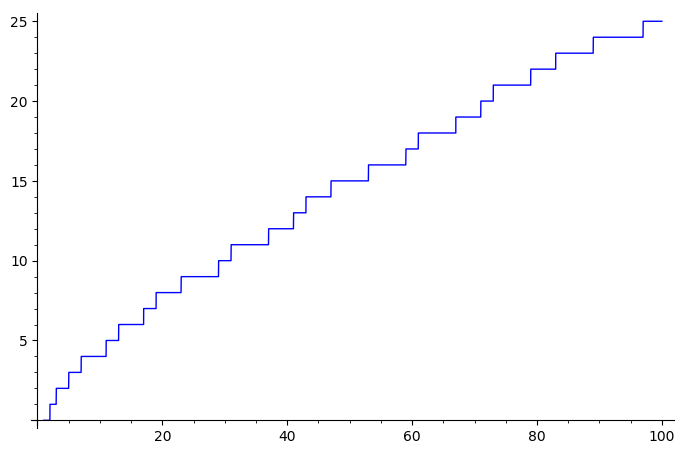

In [203]:
plot(prime_pi(x),x,1,100, figsize=7)

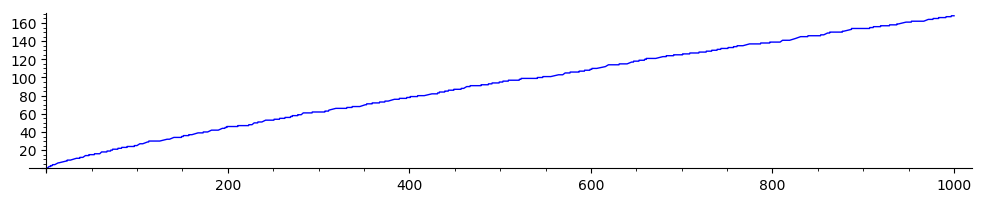

In [205]:
plot(prime_pi(x),x,1,1000, aspect_ratio=1, figsize=10)

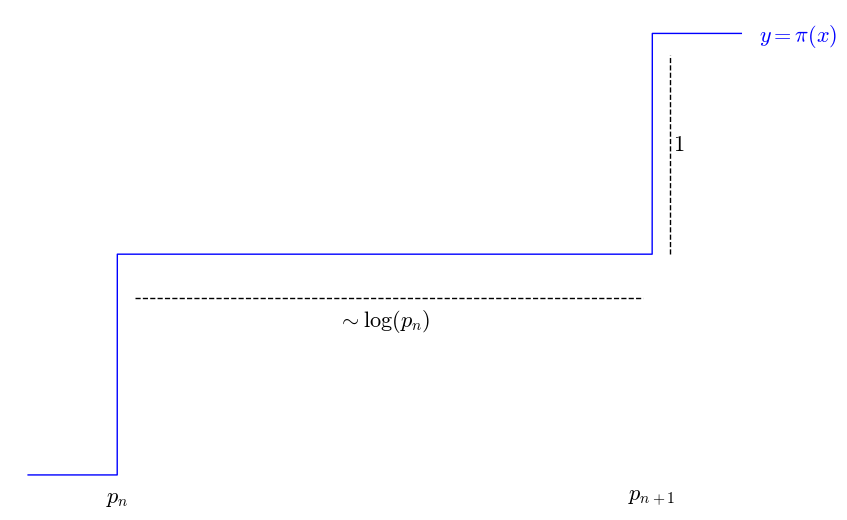

In [22]:
pp = plot(prime_pi(x), x, 22, 30)+text(r'$p_n$', (23,7.9), color='black', fontsize='16')+text(r'$p_{n+1}$', (29,7.9), color='black', fontsize='16')+text(r'$y=\pi(x)$', (30.2,10.05), color='blue', horizontal_alignment='left', vertical_alignment='top', fontsize='16')+line([(23.2,8.8),(28.9,8.8)], linestyle="--", color='black')+line([(29.2,9),(29.2,9.9)], linestyle="--", color='black')+text(r'$\sim\log(p_n)$', (26,8.7), color='black', fontsize='16')+text(r'$1$', (29.3,9.5), color='black', fontsize='16')
show(pp, axes=False, figsize=8)

<span style="font-size:2em;">
Let's modify our prime counting function so it should be asymptotic to the straight line $y=x$
    
$$ \vartheta(x) = \sum_{p\leq x}\log(p) $$
</span>

<span style="font-size:2em;">
Let's modify our prime counting function so it should be asymptotic to the straight line $y=x$
    
$$ \vartheta(x) = \sum_{p\leq x}\log(p) \sim x \qquad\text{By the Prime Number Theorem}  $$
</span>

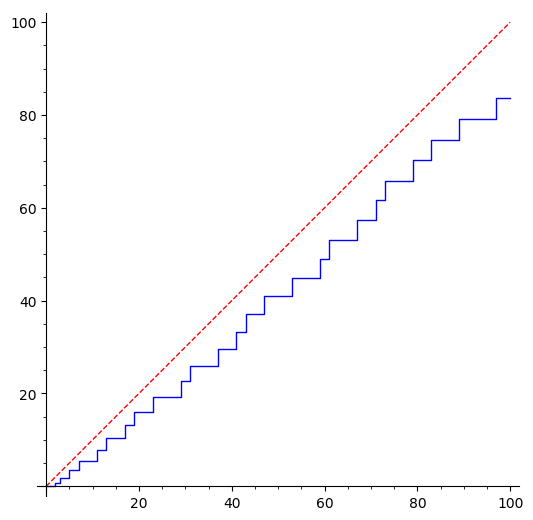

In [180]:
theta.pretty_plot(100)+plot(x,x,0,100, linestyle="--", color='red', aspect_ratio=1, figsize=8)

Linear term: y = (0.9531031721812522)x + (-4.871600373198039)


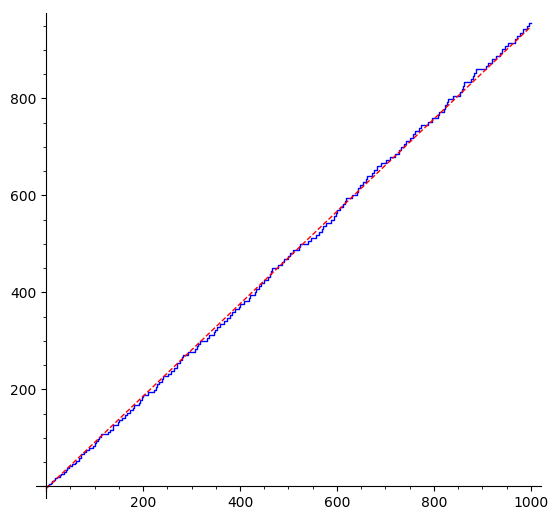

In [190]:
print(f'Linear term: y = ({theta.m})x + ({theta.c})')
theta.pretty_plot(1000)+plot(theta.m*x+theta.c,x,0,1000, linestyle="--", color='red', aspect_ratio=1, figsize=8)

<span style="font-size:2em;">
Let's subtract off the best fitting straight line and look at the error term.
</span>

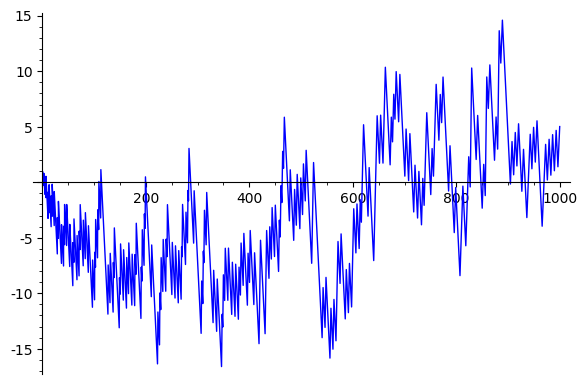

In [191]:
theta.plot_oscillating_term(1000, normalised=False, log_rescaled=False)

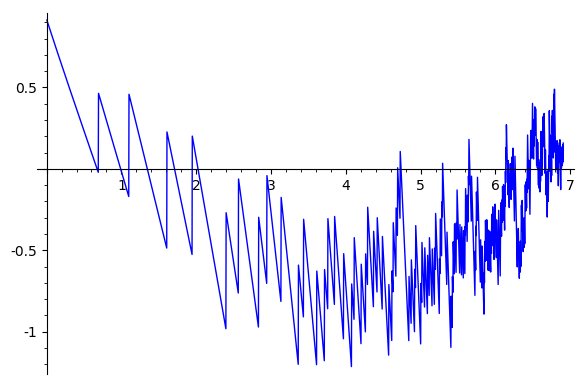

In [192]:
theta.plot_oscillating_term(1000, normalised=True, log_rescaled=True)

<span style="font-size:2em;">
What a pretty signal, let's see what it's Fourier Transform looks like!
</span>

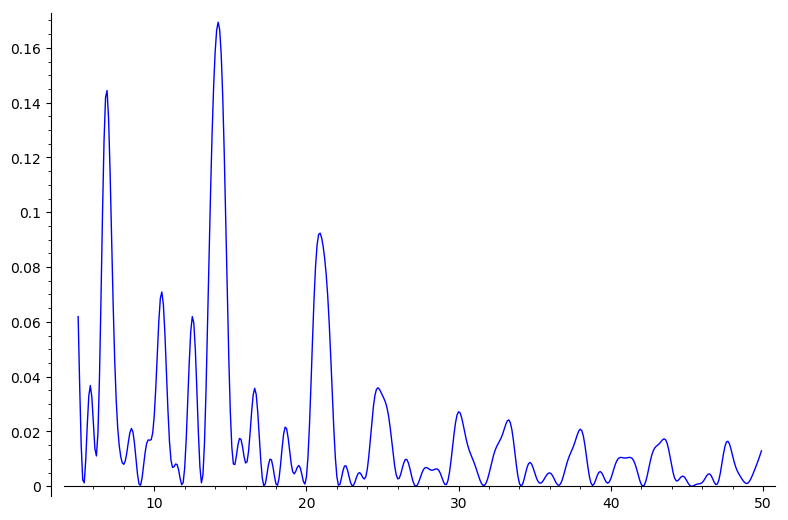

In [193]:
theta.plot_FT(recompute=False, dt=0.1, show_peaks=False, color='blue', figsize=8)

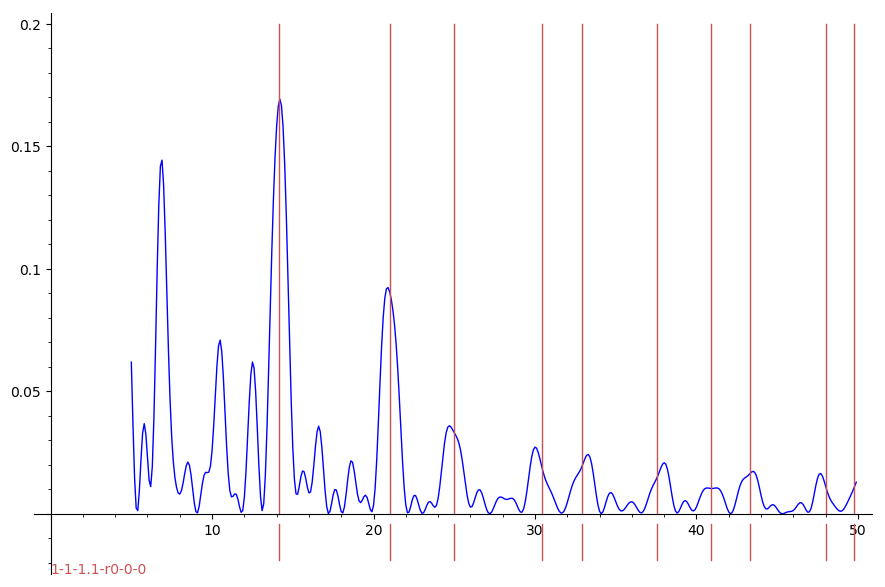

In [215]:
theta.plot_FT(recompute=False, dt=0.1, show_peaks=False, color='blue', figsize=9)+bar_codes([RZ], y_scale=0.2, t_max=50, h_start=0)

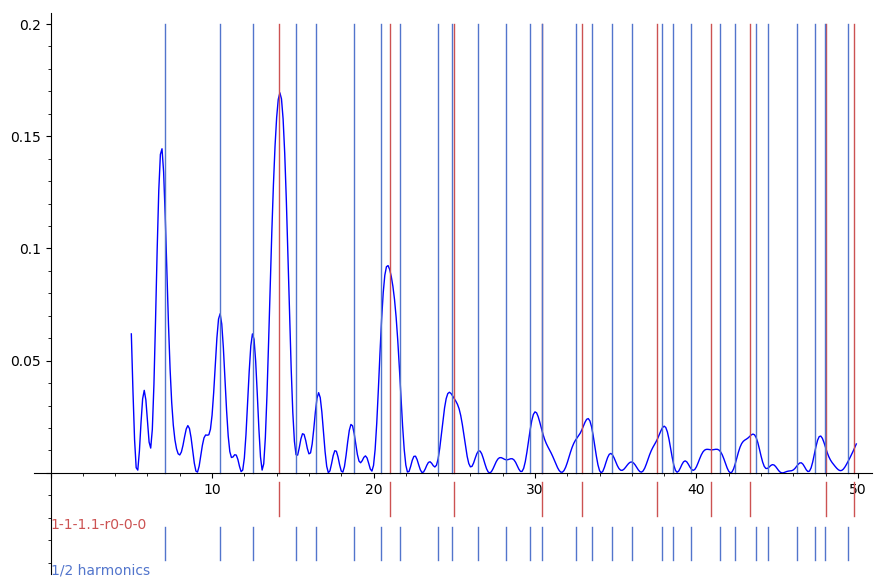

In [216]:
theta.plot_FT(recompute=False, dt=0.1, show_peaks=False, color='blue', figsize=9)+bar_codes([RZ, RZ2], y_scale=0.2, t_max=50, h_start=0)

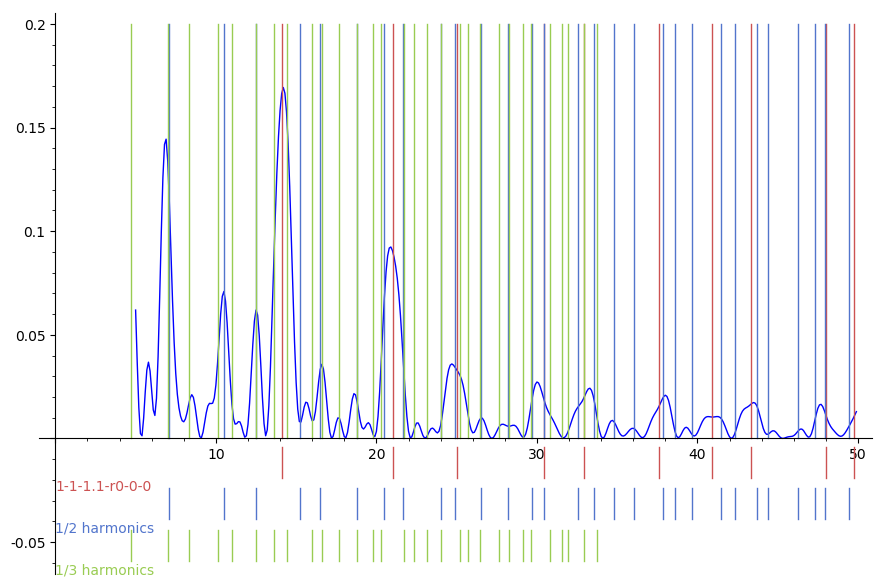

In [217]:
theta.plot_FT(recompute=False, dt=0.1, show_peaks=False, color='blue', figsize=9)+bar_codes([RZ, RZ2, RZ3], y_scale=0.2, t_max=50, h_start=0)

<span style="font-size:2em;">
Consider a slightly modified version of the $\vartheta$ function:
$$\psi(x) = \sum_{p^k \leq x}\log(p) \sim x.$$
</span>

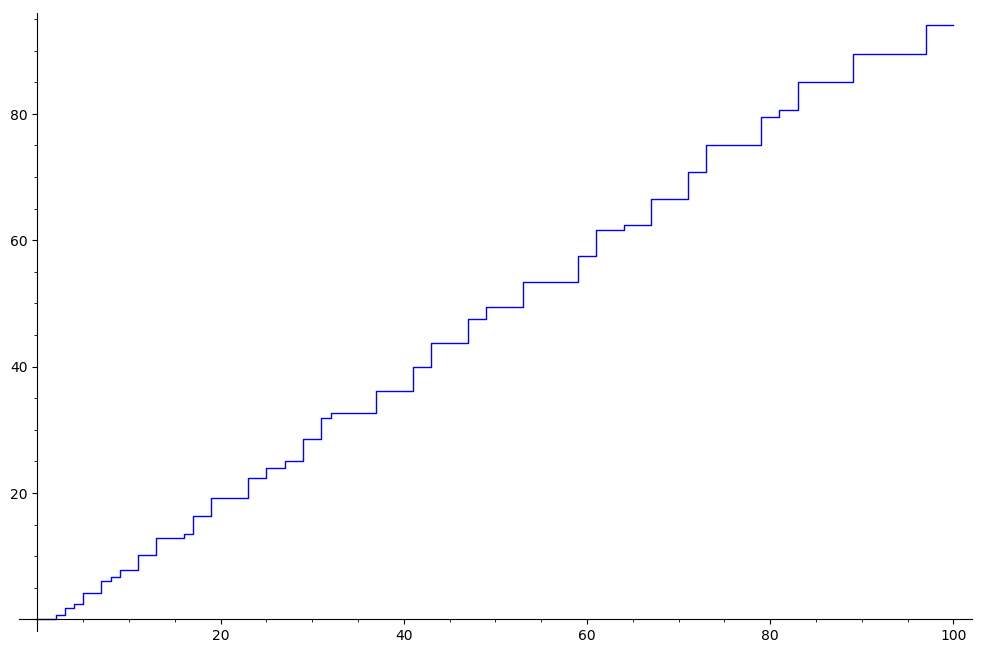

In [220]:
psi.pretty_plot(100, figsize=10)

<span style="font-size:2em;">

<h2>Explicit Formula</h2>

Consider a slightly modified version of the $\vartheta$ function:
$$\psi(x) = \sum_{p^k \leq x}\log(p) \sim x.$$

We modify it slightly, so it takes the middle value at each jump:
$$\psi_0(x) = \frac{1}{2}\big(\lim_{\varepsilon\rightarrow 0^+}\psi(x+\varepsilon)+\psi(x-\varepsilon)\big)$$ 

Then von Mangoldt's explicit formula says:
$$\psi_{0}(x)=x-\sum _{\rho }{\frac {x^{\rho }}{\rho }}-{\frac {\zeta '(0)}{\zeta (0)}}-{\tfrac {1}{2}}\log(1-x^{-2}).$$

Here $\rho = s+it$ ranges over the critical zeros of the Riemann zeta function.
    
</span>

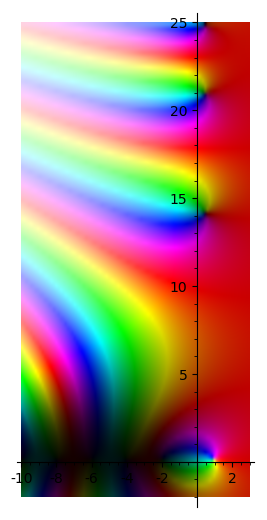

In [212]:
z = var('z')
complex_plot(zeta(z), (-10,3), (-2,25), aspect_ratio=1, figsize=8)

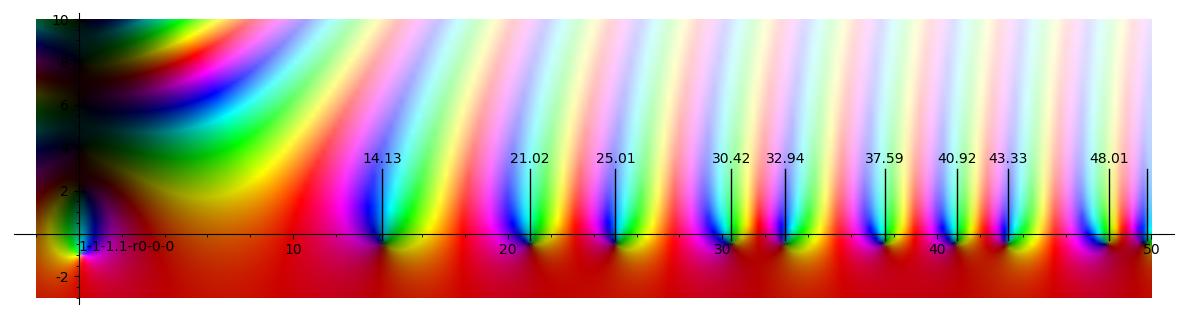

In [214]:
complex_plot(zeta(I*z), (-2,50), (-3,10), aspect_ratio=1, figsize=12, plot_points=200)+bar_codes([RZ], t_max=50, y_scale=3, v=0)+sum(text(f'{x:.2f}', (x,3.5), color='black') for x in RZ['positive_zeros'] if x<49)

<span style="font-size:2em;">
<p>So,
$$\psi_{0}(x)=\underbrace{x-{\frac {\zeta '(0)}{\zeta (0)}}}_{\text{linear}} \quad
\underbrace{-{\tfrac {1}{2}}\log(1-x^{-2})}_{\text{`trivial'}} \quad
\underbrace{-\sum _{\rho }{\frac {x^{\rho }}{\rho }}}_{\text{oscillating}}.$$

We assume that the generalised Riemann Hypothesis holds for $L$. Then each critical zero is of the form $\rho = \frac{1}{2} + it$. The oscillating term is then
\begin{align*} 
\sum_{\mathrm{Im}(\rho)\,>\,0} \frac{x^\rho}{\rho} + \frac{x^\overline\rho}{\overline\rho} 
&= \sum_{t\,>\,0} x^{\frac{1}{2}} \left[\frac{e^{it\log x}}{\rho} + \frac{e^{-it\log x}}{\overline\rho}\right] \\
&= \sum_{t\,>\,0} \sqrt{x}\cdot\frac{\cos(t\log x) + 2t\sin(t\log x)}{\frac{1}{4} + t^2} \\
&\approx \sum_{t\,>\,0} \sqrt{x}\cdot 2\frac{\sin(t\log x)}{t} \quad\text{for $t\gg 0$.}
\end{align*}
    </p></span>

<span style="font-size:2em;">
    
What about the harmonics??

Well, Riemann found an explicit formula for $\pi(x)$:
$$\pi_0(x) = \sum_{n=1}^\infty \frac{\mu(n)}{n}\mathrm{li}(x^{1/n}) 
- \sum_{\rho}\sum_{n=1}^\infty \frac{\mu(n)}{n}\mathrm{li}(x^{\rho/n})$$

Here harmonics show up in the exponents of the $x^{\rho/n}$.

There must be a similar explicit formula for $\vartheta(x)$, but I couldn't find it at short notice...
    </span>

In [197]:
psi = psi_function(vM_Lambda, extra_term=-0.5*log(1-x**(-2)), name=r'Chebychev $\psi$')
psi.Spectroscope()

HTMLMath(value='\n        <h1>Prime Spectroscope</h1> \n        <h3>Chebychev $\\psi$</h3>\n        <p>By <a h…

HTMLMath(value='Nyquist limits: \\(t_\\mathrm{min}= 0.5, \\quad\n                                t_\\mathrm{ma…

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black', max_height='600px', overflow_y='auto'))

In [198]:
psi_oeis = psi_function(l='')
psi_oeis.Spectroscope()

 does not return a unique sequence, loading A000040 prime numbers instead.


HTMLMath(value='\n        <h1>Prime Spectroscope</h1> \n        <h3>$\\psi$-function for OEIS sequence</h3>\n …

HTMLMath(value='Nyquist limits: \\(t_\\mathrm{min}= 1.1, \\quad\n                                t_\\mathrm{ma…

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black', max_height='600px', overflow_y='auto'))

In [199]:
psi_4_half = psi_function(Lambda_4_half, name=r'primes $p\equiv 1 \bmod 4$')
psi_4_half.Spectroscope()

HTMLMath(value='\n        <h1>Prime Spectroscope</h1> \n        <h3>primes $p\\equiv 1 \\bmod 4$</h3>\n       …

HTMLMath(value='Nyquist limits: \\(t_\\mathrm{min}= 0.5, \\quad\n                                t_\\mathrm{ma…

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black', max_height='600px', overflow_y='auto'))

In [200]:
theta.Spectroscope()

HTMLMath(value='\n        <h1>Prime Spectroscope</h1> \n        <h3>Chebychev $\\vartheta$-function</h3>\n    …

HTMLMath(value='Nyquist limits: \\(t_\\mathrm{min}= 0.9, \\quad\n                                t_\\mathrm{ma…

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black', max_height='600px', overflow_y='auto'))

In [222]:
random()

0.6902723598959231

In [225]:
def random_lambda(x):
    (p,k) = is_prime_power(x, get_data=True)
    if k>0:
        if random()>0.5:
            return numerical_approx(log(p))
    return 0

for x in range(20):
    print(x, random_lambda(x))

0 0
1 0
2 0
3 1.09861228866811
4 0
5 1.60943791243410
6 0
7 1.94591014905531
8 0.693147180559945
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0.693147180559945
17 2.83321334405622
18 0
19 0


In [233]:
psi_random = psi_function(random_lambda, name='random lambda function')

In [234]:
psi_random.Spectroscope()

HTMLMath(value='\n        <h1>Prime Spectroscope</h1> \n        <h3>random lambda function</h3>\n        <p>By…

HTMLMath(value='Nyquist limits: \\(t_\\mathrm{min}= 0.5, \\quad\n                                t_\\mathrm{ma…

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black', max_height='600px', overflow_y='auto'))